In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow.math import confusion_matrix
from tensorflow.keras.losses import BinaryCrossentropy

from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, TextVectorization, Input, Dense, LSTM, Bidirectional, Dropout
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

## Laden und Kombination der Daten

In [2]:
data = pd.read_csv("../data/without meta/emails.csv")
data_with_meta = pd.read_csv("../data/meta/emails_mit_Metadaten.csv")

print(len(data), len(data_with_meta))

5728 3051


In [24]:
data_with_meta.sample(5)

,Unnamed: 0,metadata,content,spam
1902,1902,From spamassassin-talk-admin@lists.sourceforge...,"\n""Craig R.Hughes"" said:\n\n> Are you filterin...",True
1427,1427,From fork-admin@xent.com Thu Oct 3 12:55:34 ...,">>>>> ""E"" == Eirikur Hallgrimsson <eh@mad.scie...",True
636,636,From ilug-admin@linux.ie Mon Oct 7 12:06:33 ...,"On Sat, Oct 05, 2002 at 06:06:14PM +0100, Padr...",True
2866,2866,From rssfeeds@jmason.org Fri Oct 4 11:02:15 ...,"URL: http://www.newsisfree.com/click/-4,851992...",True
773,773,From spamassassin-talk-admin@lists.sourceforge...,"\n""Steve Thomas"" said:\n\n> I created a user (...",True


In [4]:
data_with_meta = data_with_meta.rename(columns={"content": "text"})

In [33]:
data_with_meta.sample(5)

,Unnamed: 0,metadata,text,spam
835,835,From rpm-list-admin@freshrpms.net Wed Oct 9 ...,"Since libdvdcss-1.2.0, I have been unable to p...",True
905,905,From fork-admin@xent.com Wed Aug 28 18:07:17 ...,Mike Masnick wrote:\n>Why is it that people do...,True
1609,1609,From exmh-users-admin@redhat.com Thu Sep 19 1...,Is there any way to customise the folder table...,True
1971,1971,From spamassassin-talk-admin@lists.sourceforge...,"On Wed, 28 Aug 2002 17:45:49 -0700\nBrian McNe...",True
1446,1446,From fork-admin@xent.com Sat Oct 5 12:38:43 ...,"Greetings,\n\nCarey wants you to know about a ...",True


In [5]:
combined_data = pd.concat([data, data_with_meta[["text", "spam"]]])
len(combined_data)

8779

In [35]:
combined_data.sample(5)

,text,spam
271,Subject: re : your financial security ! high p...,1
300,Subject: make this investigator work for you ....,1
3065,"Subject: re : new business h ? lyette , i am...",0
325,NEW - NEW - NEW IN THE MARKET\nJUST RELEASED...,0
2327,Just curious if subject line capitalization ca...,1


In [6]:
X = combined_data["text"]
y = combined_data["spam"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=999)

## Erstellung des RNN

In [38]:
max_tokens = 10000
sequence_len = 256

vectorization_layer = TextVectorization(max_tokens=max_tokens, output_sequence_length=sequence_len)
vectorization_layer.adapt(X_train)

In [39]:
model = Sequential([
    Input(dtype=tf.string, shape=1),
    vectorization_layer,
    Embedding(input_dim=vectorization_layer.vocabulary_size(), output_dim=256, mask_zero=True),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.03),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.002),
    LSTM(32),
    Dense(1, activation="sigmoid"),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 256)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 256, 256)          2560000   
                                                                 
 bidirectional (Bidirectiona  (None, 256, 256)         394240    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256, 256)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256, 128)         164352    
 nal)                                                            
                                                        

In [40]:
model.compile(optimizer="adam", loss=BinaryCrossentropy(), metrics=["accuracy"])

In [41]:
history = model.fit(X_train, y_train, epochs=10, validation_split=0.15)

Epoch 1/10
164/164 [==============================] - 189s 1s/step - loss: 0.3057 - accuracy: 0.8807 - val_loss: 0.2113 - val_accuracy: 0.9360
Epoch 2/10
164/164 [==============================] - 170s 1s/step - loss: 0.1245 - accuracy: 0.9630 - val_loss: 0.1367 - val_accuracy: 0.9599
Epoch 3/10
164/164 [==============================] - 178s 1s/step - loss: 0.0771 - accuracy: 0.9774 - val_loss: 0.1654 - val_accuracy: 0.9534
Epoch 4/10
164/164 [==============================] - 154s 939ms/step - loss: 0.0727 - accuracy: 0.9761 - val_loss: 0.1640 - val_accuracy: 0.9588
Epoch 5/10
164/164 [==============================] - 144s 878ms/step - loss: 0.0456 - accuracy: 0.9856 - val_loss: 0.1813 - val_accuracy: 0.9436
Epoch 6/10
164/164 [==============================] - 122s 745ms/step - loss: 0.0390 - accuracy: 0.9887 - val_loss: 0.1464 - val_accuracy: 0.9566
Epoch 7/10
164/164 [==============================] - 119s 726ms/step - loss: 0.0268 - accuracy: 0.9922 - val_loss: 0.1477 - val_accu

In [42]:
model.save("rnn_model_combined.tf")

INFO:tensorflow:Assets written to: rnn_model_combined.tf\assets


INFO:tensorflow:Assets written to: rnn_model_combined.tf\assets


## Evaluierung

In [10]:
model = tf.keras.models.load_model("../Application/models/text/RNN/rnn_model_combined.tf")

c:\Users\Daniel\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\saving\saved_model\load.py:115: RuntimeWarning: Unexpected end-group tag: Not all data was converted
  metadata.ParseFromString(file_content)


In [11]:
accuracy = model.evaluate(X_test, y_test, verbose=0)
print("test loss, test accuracy:", accuracy)

test loss, test accuracy: [0.21420712769031525, 0.9468488693237305]


In [44]:
y_pred = model.predict(X_test)
y_pred_bin = np.round(y_pred)

confusion = confusion_matrix(labels=y_test, predictions=y_pred_bin)

83/83 [==============================] - 20s 172ms/step


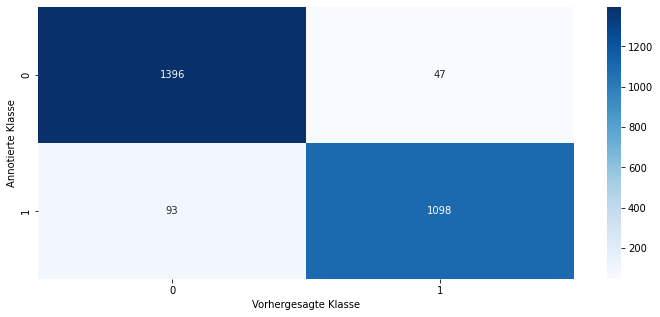

In [45]:
plt.figure(figsize=(12,5))
sns.heatmap(confusion, annot=True, fmt="d", cmap=plt.cm.Blues)

plt.xlabel("Vorhergesagte Klasse")
plt.ylabel("Annotierte Klasse")
plt.show()

In [1]:
tp = confusion[1][1]
fp = confusion[0][1]
fn = confusion[1][0]

precision = tp / (tp + fp)
recall = tp / (tp + fn)

print("Precision, Recall:", float(precision), float(recall))

Precision, Recall: 0.9589519650655022 0.9219143576826196
